In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## Input datasets
I read from 5 datasets and combine them toghether

because of the datasets fault, I can't separate them in file reading time, so I read it as a 1 column

In [107]:
csv1 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part1.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
#csv2 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part2.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
csv3 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part3.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
csv4 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part4.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
#csv5 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part5.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)

In [115]:
data = pd.DataFrame(columns=['All'])
data = data.append(csv1, ignore_index=True)
#data = data.append(csv2, ignore_index=True)
data = data.append(csv3, ignore_index=True)
data = data.append(csv4, ignore_index=True)
#data = data.append(csv5, ignore_index=True)
data

,All
0,ویکی‌پدیای\tO
1,انگلیسی\tO
2,در\tB-DAT
3,تاریخ\tI-DAT
4,۱۵\tI-DAT
...,...
7888386,روی\tO
7888387,میز\tO
7888388,گزارشگران\tO
7888389,کوبیدند\tO


In [116]:
dataTmp = data['All'].str.rsplit("\t", 1)
data = pd.DataFrame(list(dataTmp), columns = ['Token', 'NameEntity'])
data

,Token,NameEntity
0,ویکی‌پدیای,O
1,انگلیسی,O
2,در,B-DAT
3,تاریخ,I-DAT
4,۱۵,I-DAT
...,...,...
7888386,روی,O
7888387,میز,O
7888388,گزارشگران,O
7888389,کوبیدند,O


(-1.105133142817516,
 1.1063937261521093,
 -1.1210925135745438,
 1.1010044066080147)

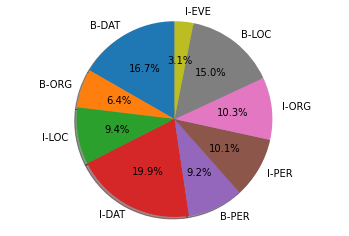

In [119]:
x = data['NameEntity'].value_counts()[1:-1]
x = shuffle(x)
fig1, ax1 = plt.subplots()
ax1.pie(x.values, labels=x.keys(), autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') 

In [121]:
data['NameEntity'].value_counts()

O        6480678
I-DAT     275684
B-DAT     231599
B-LOC     207310
I-ORG     143370
I-PER     139528
I-LOC     130272
B-PER     126881
B-ORG      88488
I-EVE      43170
B-EVE      21400
Name: NameEntity, dtype: int64

In [53]:
csv5 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part5.txt", header=None, delimiter="^", names = ['a'], error_bad_lines=False, encoding_errors = 'ignore', low_memory=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


ParserError: ignored

In [85]:
tmp = csv1['a'].str.rsplit("\t", 1)


In [86]:
data1 = pd.DataFrame(list(tmp), columns = ['Token', 'NameEntity'])

(-1.1148730893698715,
 1.1009225463724794,
 -1.1091849286947753,
 1.100437377556894)

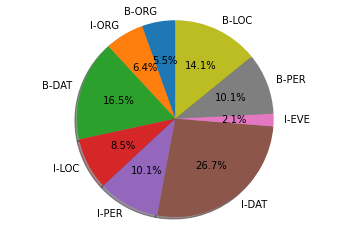

In [87]:
x = data['NameEntity'].value_counts()[1:-1]
x = shuffle(x)
fig1, ax1 = plt.subplots()
ax1.pie(x.values, labels=x.keys(), autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') 


In [89]:
data1['NameEntity'].isna().sum()

2

In [90]:
nanIndices = data1['NameEntity'][data1['NameEntity'].isnull().values].index

In [102]:
data1.iloc[nanIndices]

,Token,NameEntity
1193638,http://turnbull.mcs.st-and.ac.uk/,O
2569124,http://kiau.ac.ir/,O


In [101]:
data1 = data1.fillna('O')

In [104]:
data1.iloc[nanIndices]

,Token,NameEntity
1193638,http://turnbull.mcs.st-and.ac.uk/,O
2569124,http://kiau.ac.ir/,O
